# Question 4 – Air Passengers Forecasting with Exponential Smoothing
Dataset: `air-passengers.csv`.

We now use Holt–Winters exponential smoothing.

In [14]:
import os, math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error

def load_air_passengers():
    for p in ['air-passengers.csv', 'air_passengers.csv', '/mnt/data/air-passengers.csv', '/mnt/data/air_passengers.csv']:
        if os.path.exists(p):
            path = p
            break
    else:
        raise FileNotFoundError('air-passengers.csv not found')
    df = pd.read_csv(path)
    date_col_candidates = [c for c in df.columns if 'date' in c.lower() or 'month' in c.lower()]
    date_col = date_col_candidates[0] if date_col_candidates else df.columns[0]
    value_col_candidates = [c for c in df.columns if 'passenger' in c.lower() or 'value' in c.lower()]
    value_col = value_col_candidates[0] if value_col_candidates else df.columns[1]
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.set_index(date_col).asfreq('MS')
    df = df.rename(columns={value_col: 'Passengers'})
    return df

air_ts = load_air_passengers()
air_ts.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## 4(a) Question – Which Exponential-Smoothing Model?
> Suppose you want to forecast the total number of monthly passengers using exponential smoothing.
> Which type of exponential-smoothing model should be used? Explain your reasons.

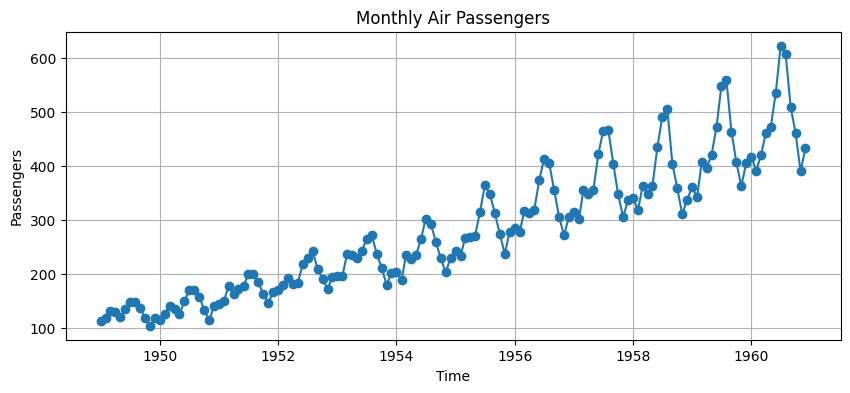

In [15]:
# 4(a) – Plot series

plt.figure(figsize=(10,4))
plt.plot(air_ts.index, air_ts['Passengers'], marker='o', linestyle='-')
plt.title('Monthly Air Passengers')
plt.xlabel('Time')
plt.ylabel('Passengers')
plt.grid(True)
plt.show()

### 4(a) Explanation – Holt–Winters Multiplicative Model

The plot shows:
- Strong **trend**.
- Clear **seasonality** with period 12.
- Increasing **amplitude** of seasonal swings.

According to the time-series slides:
- **Simple exponential smoothing**: no trend, no seasonality.
- **Holt’s method**: trend but no seasonality.
- **Holt–Winters additive**: trend + additive seasonality (constant amplitude).
- **Holt–Winters multiplicative**: trend + multiplicative seasonality (amplitude proportional to level).

Thus, the appropriate choice is **Holt–Winters exponential smoothing with multiplicative trend and seasonality**.

## 4(b) Question – Parameter Selection and Implementation
> How do you determine the best parameters for your exponential-smoothing model? Implement code
> to fit the best model using the last 12 months as test data.

{'smoothing_level': np.float64(0.37622239842195293), 'smoothing_trend': np.float64(0.0), 'smoothing_seasonal': np.float64(0.6237776015780471), 'damping_trend': nan, 'initial_level': np.float64(124.65407671290268), 'initial_trend': np.float64(3.0182525792574806), 'initial_seasons': array([0.87724549, 0.92352702, 1.01506971, 0.96501108, 0.8917954 ,
       0.97484713, 1.06085045, 1.04685691, 0.95447489, 0.83206697,
       0.7400465 , 0.85350414]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


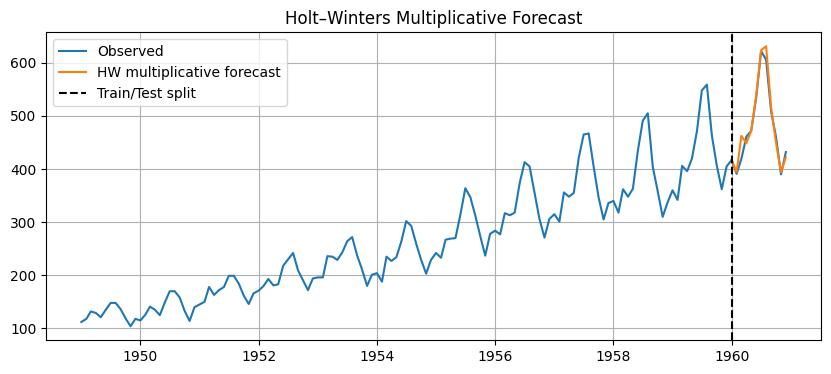

In [16]:
# 4(b) – Fit Holt–Winters multiplicative model

train = air_ts.iloc[:-12]['Passengers']
test = air_ts.iloc[-12:]['Passengers']

hw_model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='mul',
    seasonal_periods=12
).fit(optimized=True)

print(hw_model.params)

hw_forecast = hw_model.forecast(12)

fig, ax = plt.subplots(figsize=(10,4))
ax.plot(air_ts.index, air_ts['Passengers'], label='Observed')
ax.plot(test.index, hw_forecast, label='HW multiplicative forecast')
ax.axvline(test.index[0], color='k', linestyle='--', label='Train/Test split')
ax.set_title('Holt–Winters Multiplicative Forecast')
ax.legend()
ax.grid(True)
plt.show()

### 4(b) Explanation – Smoothing Parameters

Holt–Winters multiplicative model updates level $\ell_t$, trend $b_t$, and seasonal indices $s_t$ using smoothing
parameters $\alpha, \beta, \gamma$ (see slides):
- Level:  
  $$ \ell_t = \alpha \frac{y_t}{s_{t-m}} + (1-\alpha)(\ell_{t-1} + b_{t-1}), $$
- Trend:  
  $$ b_t = \beta (\ell_t - \ell_{t-1}) + (1-\beta) b_{t-1}, $$
- Seasonal:  
  $$ s_t = \gamma \frac{y_t}{\ell_t} + (1-\gamma) s_{t-m}. $$

The software chooses $\alpha, \beta, \gamma$ (and initial values) by minimizing **SSE** on the training data, which is
consistent with the method in the lecture notes.

## 4(c) Question – Measuring Performance of Exponential-Smoothing Model
> How do you measure whether your exponential-smoothing model has good performance? Implement
> code to check this performance measure.

In [17]:
# 4(c) – Evaluate Holt–Winters model using MAPE

mape_hw = mean_absolute_percentage_error(test, hw_forecast)
print("Holt–Winters multiplicative MAPE (%):", mape_hw)

Holt–Winters multiplicative MAPE (%): 0.022074221877743234


### 4(c) Explanation – Performance Measure

We use **MAPE** as in previous questions:
$$ \text{MAPE} = \frac{100\%}{n} \sum_{t=1}^n \left| \frac{y_t - \hat{y}_t}{y_t} \right|. $$

We compute MAPE on the last 12 months (test set). A lower MAPE indicates better performance. We can also compare
this Holt–Winters MAPE with that from SARIMA (Question 3) and simple benchmarks to choose the best forecasting
model for this series.

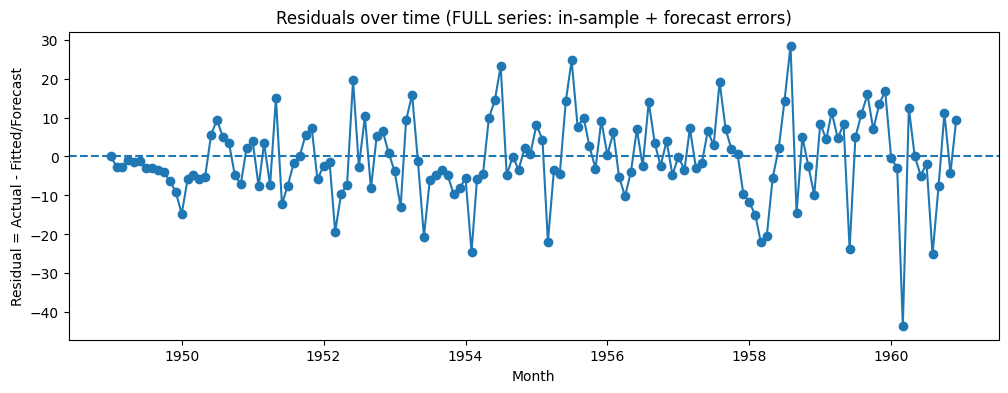

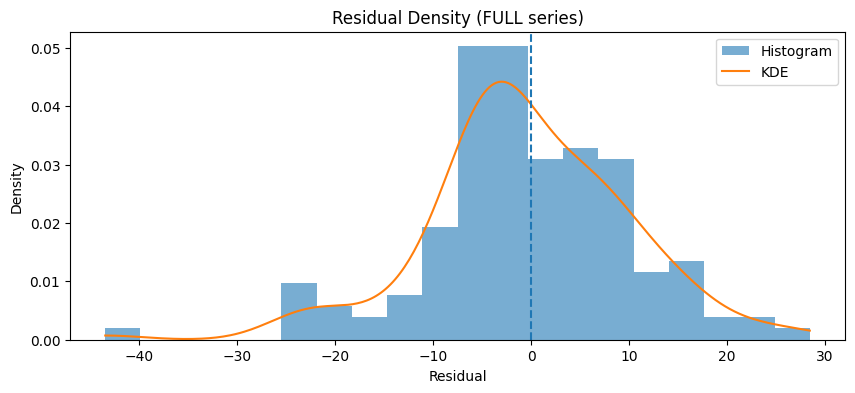

,lb_stat,lb_pvalue
12,21.048097,0.049681
24,45.672894,0.004845


In [18]:
# 4(d) – Residual diagnostics on the FULL dataset (train + test)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import gaussian_kde

# 1) Build residuals for TRAIN (in-sample fit)
# hw_model was fitted on `train` in 4(b)
fitted_train = pd.Series(hw_model.fittedvalues, index=train.index)
resid_train = train - fitted_train

# 2) Build residuals for TEST (forecast errors)
# hw_forecast was generated in 4(b)
hw_forecast = pd.Series(hw_forecast, index=test.index)
resid_test = test - hw_forecast

# 3) Combine to cover ALL observations in the CSV
residuals_all = pd.concat([resid_train, resid_test]).sort_index()
residuals_all.name = "residual"
residuals_all.head(), residuals_all.tail()

# ---- Plot residuals over time (FULL series) ----
plt.figure(figsize=(12,4))
plt.plot(residuals_all.index, residuals_all, marker='o', linestyle='-')
plt.axhline(0, linestyle='--')
plt.title('Residuals over time (FULL series: in-sample + forecast errors)')
plt.xlabel('Month')
plt.ylabel('Residual = Actual - Fitted/Forecast')
plt.show()

# ---- Residual density (Histogram + KDE) ----
vals = residuals_all.dropna().values

plt.figure(figsize=(10,4))
plt.hist(vals, bins=20, density=True, alpha=0.6, label='Histogram')

kde = gaussian_kde(vals)
xs = np.linspace(vals.min(), vals.max(), 300)
plt.plot(xs, kde(xs), label='KDE')

plt.axvline(0, linestyle='--')
plt.title('Residual Density (FULL series)')
plt.xlabel('Residual')
plt.ylabel('Density')
plt.legend()
plt.show()

# ---- Ljung–Box test (autocorrelation in residuals) ----
# H0: residuals are independent (no autocorrelation)
# If p-value > 0.05 -> fail to reject H0 -> residuals look like white noise (good)

lb = acorr_ljungbox(residuals_all.dropna(), lags=[12, 24], return_df=True)
lb
